## 猜词游戏 2-1



In [3]:
## 导入会使用到的库
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(font= "simsun",style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False # 解决坐标轴的负号显示问题
## 导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from io import StringIO
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import nltk

import graphviz
import pydotplus
from IPython.display import Image  

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

## 主要对第二问进行建模与分析

问题2：预测未来日期 (1, 2, 3, 4, 5, 6, X) 的相关百分比。举一个你对2023年3月1日EERIE这个词的预测的具体例子。你对你的模型的预测有多自信？

也可以考虑使用时间序列模型进行数值的预测，但是一元的时间序列模型进行预测，并不能使用到字母的情况。因此下面不再解释使用时间序列进行分别预测，时间序列的预测程序可以参考分析1，作数据替换即可得到相应的分析结果。

### 思路：针对每个(1, 2, 3, 4, 5, 6, X) 的相关百分比，分别建立模型进行预测。

主要建立每个单词的出现次序对(1, 2, 3, 4, 5, 6, X) 的相关百分比的影响情况。

#### 首先以 1 为例进行建模与分析

### 数据准备

In [4]:
## 数据保存
df = pd.read_excel("Problem_C_Data_Wordle_clean_all.xlsx",date_parser=["Date"])
df = df.sort_values(by = "Date").reset_index(drop = True)
df

,Date,Contest_number,Word,Number_of_reported_results,Number_in_hard_mode,tries1,tries2,tries3,tries4,tries5,tries6,triesX,word1,word2,word3,word4,word5,Tag
0,2022-01-07,202,slump,80630,1362,1,3,23,39,24,9,1,s,l,u,m,p,NN
1,2022-01-08,203,crank,101503,1763,1,5,23,31,24,14,2,c,r,a,n,k,NN
2,2022-01-09,204,gorge,91477,1913,1,3,13,27,30,22,4,g,o,r,g,e,NN
3,2022-01-10,205,query,107134,2242,1,4,16,30,30,17,2,q,u,e,r,y,JJ
4,2022-01-11,206,drink,153880,3017,1,9,35,34,16,5,1,d,r,i,n,k,VB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2022-12-27,556,condo,20879,2012,0,2,17,35,29,14,3,c,o,n,d,o,NN
355,2022-12-28,557,impel,20160,1937,0,3,21,40,25,9,1,i,m,p,e,l,NN
356,2022-12-29,558,havoc,20001,1919,0,2,16,38,30,12,2,h,a,v,o,c,NN
357,2022-12-30,559,molar,21204,1973,0,4,21,38,26,9,1,m,o,l,a,r,JJ


In [5]:
df.columns

Index(['Date', 'Contest_number', 'Word', 'Number_of_reported_results',
       'Number_in_hard_mode', 'tries1', 'tries2', 'tries3', 'tries4', 'tries5',
       'tries6', 'triesX', 'word1', 'word2', 'word3', 'word4', 'word5', 'Tag'],
      dtype='object')

In [6]:
## 对数据进行特征工程预处理准备工作

df2 = df[["tries1","word1","word2","word3","word4","word5"]]
df2["Tag"] = df["Tag"]
df2["Tag"][~((df["Tag"] == "NN") | (df["Tag"] == "JJ"))] = "Other"
## 添加月份和天特征
df2["month"] = df["Date"].dt.month
df2["day"] = df["Date"].dt.day
df2

,tries1,word1,word2,word3,word4,word5,Tag,month,day
0,1,s,l,u,m,p,NN,1,7
1,1,c,r,a,n,k,NN,1,8
2,1,g,o,r,g,e,NN,1,9
3,1,q,u,e,r,y,JJ,1,10
4,1,d,r,i,n,k,Other,1,11
...,...,...,...,...,...,...,...,...,...
354,0,c,o,n,d,o,NN,12,27
355,0,i,m,p,e,l,NN,12,28
356,0,h,a,v,o,c,NN,12,29
357,0,m,o,l,a,r,JJ,12,30


<AxesSubplot:>

findfont: Font family ['simsun'] not found. Falling back to DejaVu Sans.


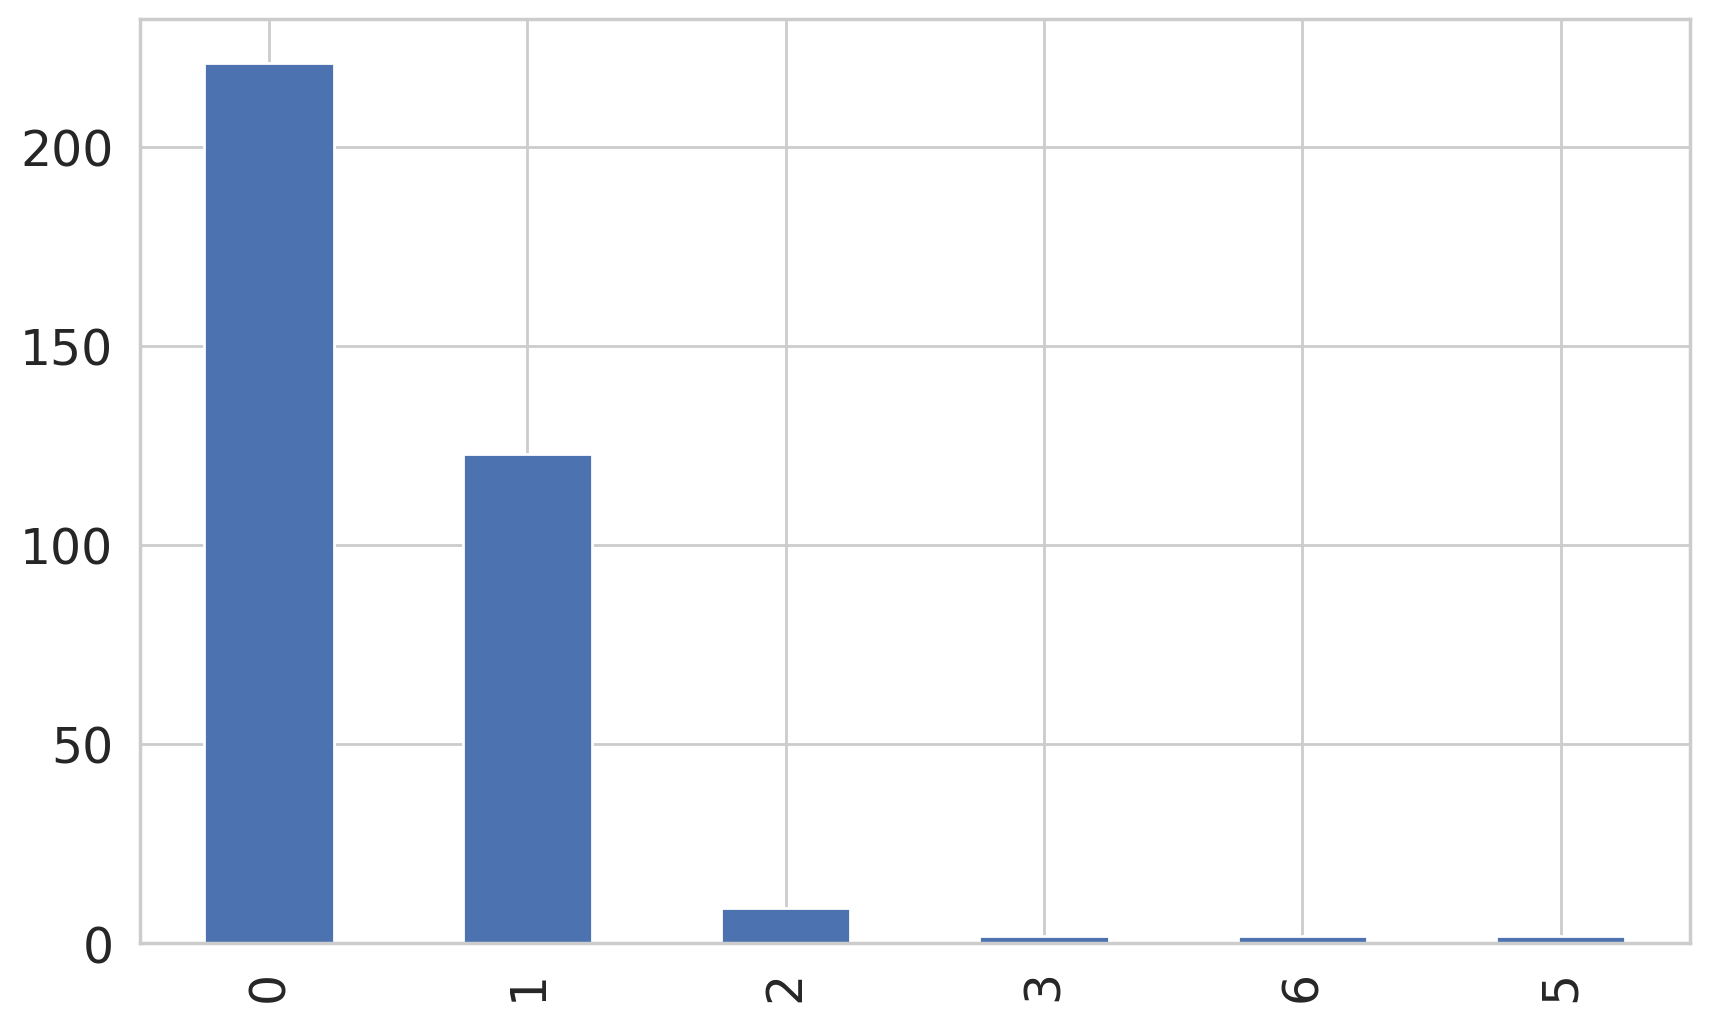

In [7]:
df2["tries1"].value_counts().plot(kind = "bar",figsize = (10,6))

## 大部分的取值为0

In [8]:
df2["Tag"].value_counts()

NN       212
JJ        76
Other     71
Name: Tag, dtype: int64

In [9]:
## 对字母变了进行编码
letter = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
          'p','q','r','s','t','u','v','w','x','y','z']
le1 = LabelEncoder()
le1.fit(letter)
le2 = LabelEncoder()
le2.fit(["NN","JJ","Other"])
le2

LabelEncoder()

In [10]:
## 对字母进行编码
df2["word1"] = le1.transform(df2["word1"])
df2["word2"] = le1.transform(df2["word2"])
df2["word3"] = le1.transform(df2["word3"])
df2["word4"] = le1.transform(df2["word4"])
df2["word5"] = le1.transform(df2["word5"])
df2["Tag"] = le2.transform(df2["Tag"])
df2

,tries1,word1,word2,word3,word4,word5,Tag,month,day
0,1,18,11,20,12,15,1,1,7
1,1,2,17,0,13,10,1,1,8
2,1,6,14,17,6,4,1,1,9
3,1,16,20,4,17,24,0,1,10
4,1,3,17,8,13,10,2,1,11
...,...,...,...,...,...,...,...,...,...
354,0,2,14,13,3,14,1,12,27
355,0,8,12,15,4,11,1,12,28
356,0,7,0,21,14,2,1,12,29
357,0,12,14,11,0,17,0,12,30


In [11]:
df2.columns

Index(['tries1', 'word1', 'word2', 'word3', 'word4', 'word5', 'Tag', 'month',
       'day'],
      dtype='object')

In [12]:
## 数据切分为训练集和验证集

# 定于预测目标变量名
Target = ["tries1"]
## 定义模型的自变量名
train_x = ['word1', 'word2', 'word3', 'word4', 'word5', 'Tag', 'month','day']

##将训练集切分为训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(df2[train_x], df2[Target],
                                               test_size = 0.25,random_state = 1)
print("X_train.shape :",X_train.shape)
print("X_val.shape :",X_val.shape)
print(X_train.head())
X_train.head()

X_train.shape : (269, 8)
X_val.shape : (90, 8)
     word1  word2  word3  word4  word5  Tag  month  day
211      0     11      8      4     13    1      8    6
318      0     23      8     14     12    1     11   21
346     18     11      0     19      4    1     12   19
192      5     11     14      2     10    1      7   18
270      1     14     20      6      7    2     10    4


,word1,word2,word3,word4,word5,Tag,month,day
211,0,11,8,4,13,1,8,6
318,0,23,8,14,12,1,11,21
346,18,11,0,19,4,1,12,19
192,5,11,14,2,10,1,7,18
270,1,14,20,6,7,2,10,4


In [13]:
nltk.pos_tag(["eerie"])

[('eerie', 'NN')]

In [14]:
## 准备带预测数据  2023年3月1日EERIE单词预测
X_test = pd.DataFrame(data={"word1":le1.transform(["e"]),
                            "word2":le1.transform(["e"]),
                            "word3":le1.transform(["r"]),
                            "word4":le1.transform(["i"]),
                            "word5":le1.transform(["e"]),
                            "Tag":le2.transform(["NN"]),
                            "month":3,"day":1})
X_test

,word1,word2,word3,word4,word5,Tag,month,day
0,4,4,17,8,4,1,3,1


## 决策树预测模型 （数据回归模型）

In [15]:
## 先使用默认的参数建立一个决策树回归
dtc1 = DecisionTreeRegressor(random_state=1)
## 使用训练数据进行训练
dtc1 = dtc1.fit(X_train, y_train)
## 输出其在训练数据和验证数据集上的预测精度
dtc1_lab = np.round(dtc1.predict(X_train))
dtc1_pre = np.round(dtc1.predict(X_val))
print("训练数据集上的绝对值误差:",mean_absolute_error(y_train,dtc1_lab))
print("验证数据集上的绝对值误差:",mean_absolute_error(y_val,dtc1_pre))

## 训练机上预测全部正确，但是验证集上预测绝对值误差为0.65


训练数据集上的绝对值误差: 0.0
验证数据集上的绝对值误差: 0.6555555555555556


In [16]:
## 对模型进行优化
## 使用较合适的参数建立决策树回归
dtc2 = DecisionTreeRegressor(max_depth=3, ## 最大深度
                              random_state=1)
dtc2 = dtc2.fit(X_train,y_train)
## 输出其在训练数据和验证数据集上的预测精度
dtc2_lab = np.round(dtc2.predict(X_train))
dtc2_pre = np.round(dtc2.predict(X_val))
print("训练数据集上的绝对值误差:",mean_absolute_error(y_train,dtc2_lab))
print("验证数据集上的绝对值误差:",mean_absolute_error(y_val,dtc2_pre))

训练数据集上的绝对值误差: 0.2825278810408922
验证数据集上的绝对值误差: 0.35555555555555557


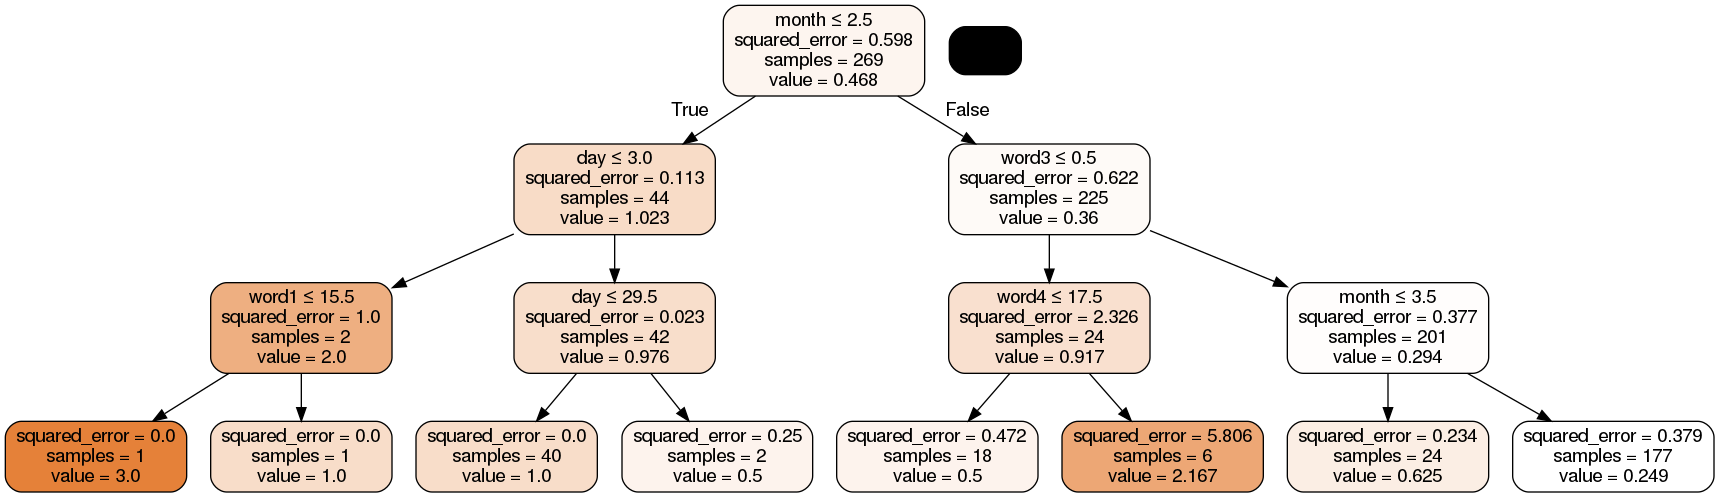

In [17]:
## 可视化决策树模型
dot_data = StringIO()
export_graphviz(dtc2, out_file=dot_data,
                feature_names=X_train.columns,
                filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [18]:
## 使用深度为3的决策树模型，使用全部的数据重新训练模型，并且对待预测的数据进行预测
dtc3 = DecisionTreeRegressor(max_depth=3, ## 最大深度
                              random_state=1)
dtc3 = dtc3.fit(df2[train_x], df2[Target])
## 输出其在训练数据上的预测精度
dtc3_lab = np.round(dtc3.predict(df2[train_x]))
dtc3_pre = np.round(dtc3.predict(X_test))
print("训练数据集上的绝对值误差:",mean_absolute_error(df2[Target],dtc3_lab))
print("预测结果:",dtc3_pre)  # 误差并不是很高

训练数据集上的绝对值误差: 0.30362116991643456
预测结果: [2.]


## 试试随机森林回归模型

In [19]:
## 使用随机森林对泰坦尼克数据进行分类
rfc1 = RandomForestRegressor(n_estimators = 500, # 树的数量
                              max_depth= 2,       # 子树最大深度
                              oob_score=True, 
                              random_state=1)
rfc1.fit(X_train,y_train)
## 输出其在训练数据和验证数据集上的预测精度
rfc1_lab = np.round(rfc1.predict(X_train))
rfc1_pre = np.round(rfc1.predict(X_val))
print("随机森林的OOB score:",rfc1.oob_score_)
print("训练数据集上的绝对值误差:",mean_absolute_error(y_train,rfc1_lab))
print("验证数据集上的绝对值误差:",mean_absolute_error(y_val,rfc1_pre))

## 验证集上预测绝对值误差为0.3


随机森林的OOB score: 0.0949090675773615
训练数据集上的绝对值误差: 0.2862453531598513
验证数据集上的绝对值误差: 0.3


In [20]:
## 使用随机森林模型，使用全部的数据重新训练模型，并且对待预测的数据进行预测
rfc3 = RandomForestRegressor(n_estimators = 500, # 树的数量
                              max_depth= 2,       # 子树最大深度
                              oob_score=True, 
                              random_state=1)
rfc3 = rfc3.fit(df2[train_x], df2[Target])
## 输出其在训练数据上的预测精度
rfc3_lab = np.round(rfc3.predict(df2[train_x]))
rfc3_pre = np.round(rfc3.predict(X_test))
print("训练数据集上的绝对值误差:",mean_absolute_error(df2[Target],rfc3_lab))
print("预测结果:",rfc3_pre)  # 误差并不是很高

## 预测结果和决策树模型一致

训练数据集上的绝对值误差: 0.298050139275766
预测结果: [1.]


## 梯度提升树（GBDT）回归模型

In [21]:
## 使用参数网格搜索寻找合适的GBDT参数用于模型的建立
gbdt1 = GradientBoostingRegressor(random_state=1,
                                 n_estimators = 50,
                                 max_depth = 3,learning_rate=0.01,
                                ) ## 定义模型
gbdt1.fit(X_train,y_train)
## 输出其在训练数据和验证数据集上的预测精度
gbdt1_lab = np.round(gbdt1.predict(X_train))
gbdt1_pre = np.round(gbdt1.predict(X_val))
print("训练数据集上的绝对值误差:",mean_absolute_error(y_train,gbdt1_lab))
print("验证数据集上的绝对值误差:",mean_absolute_error(y_val,gbdt1_pre))

## 验证集上预测绝对值误差为0.377,效果并没有比随机森林好一些

训练数据集上的绝对值误差: 0.2788104089219331
验证数据集上的绝对值误差: 0.37777777777777777


## 尝试支持向量机回归模型

In [22]:
## 建立一个rbf核支持向量机回归模型，探索回归模型的效果
rbfsvr = SVR(kernel = "poly",degree=1)
rbfsvr.fit(X_train,y_train)
## 输出其在训练数据和验证数据集上的预测精度
rbfsvr_lab = np.round(rbfsvr.predict(X_train))
rbfsvr_pre = np.round(rbfsvr.predict(X_val))
print("训练数据集上的绝对值误差:",mean_absolute_error(y_train,rbfsvr_lab))
print("验证数据集上的绝对值误差:",mean_absolute_error(y_val,rbfsvr_pre))

## 验证集上预测绝对值误差为0.288,效果比随机森林好一些


训练数据集上的绝对值误差: 0.29739776951672864
验证数据集上的绝对值误差: 0.28888888888888886


In [23]:
## 使用支持向量机回归模型,使用全部的数据重新训练模型，并且对待预测的数据进行预测
rbfsvr = SVR(kernel = "poly",degree=1)
rbfsvr = dtc2.fit(df2[train_x], df2[Target])
## 输出其在训练数据上的预测精度
rbfsvr_lab = np.round(rbfsvr.predict(df2[train_x]))
rbfsvr_pre = np.round(rbfsvr.predict(X_test))
print("训练数据集上的绝对值误差:",mean_absolute_error(df2[Target],rbfsvr_lab))
print("预测结果:",rbfsvr_pre)  # 误差并不是很高

## 预测结果和决策树模型一致,误差和随机森林差不多

训练数据集上的绝对值误差: 0.30362116991643456
预测结果: [2.]


## 尝试全联接神经网络回归

In [24]:
## 使用未标准化的数据,利用MLP进行回归分析
mlpr1 = MLPRegressor(hidden_layer_sizes = (100,100),
                     activation = "relu",batch_size = 32,
                     learning_rate = "adaptive",random_state = 1,
                     max_iter = 2000)
mlpr1.fit(X_train,y_train)
## 输出其在训练数据和验证数据集上的预测精度
mlpr1_lab = np.round(mlpr1.predict(X_train))
mlpr1_pre = np.round(mlpr1.predict(X_val))
print("训练数据集上的绝对值误差:",mean_absolute_error(y_train,mlpr1_lab))
print("验证数据集上的绝对值误差:",mean_absolute_error(y_val,mlpr1_pre))

## 神经网络回归的预测效果并不好


训练数据集上的绝对值误差: 0.01486988847583643
验证数据集上的绝对值误差: 0.6444444444444445
